In [517]:
import numpy as np
import pandas as pd
import re

# Para visualizar
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import bokeh.plotting as bkplt
from bokeh.io import output_file, show
from bokeh.layouts import gridplot, column
from bokeh.models import HoverTool, Div


#contenido
from nltk.corpus import stopwords
from wordcloud import WordCloud
import emoji
from collections import Counter


In [518]:
#acá deben cargar su primer nombre como aparece en Whatsapp para que el script pueda diferenciar sus mensajes 
#de los de su interlocutor
mi_nombre = "Isabel"

In [519]:
#ingresar el nombre del archivo que van a analizar
file = open(r'Chat de Whatsapp.txt',mode='r',encoding="utf8")
data = file.read()
file.close()


In [520]:
def split_text(data):
  ##  Generamos una linea por cada salto de linea.

    return data.splitlines()

In [521]:
LineasChat = split_text(data)

In [522]:
len(LineasChat)

40357

In [523]:
#busco la fecha con regex y hago una lista con todas las fechas
def fecha(LineasChat):
    fecha = []
    regTime = re.compile("\d+/\d+/\d+")
    for index, line in enumerate(LineasChat):
        matches = re.findall(regTime, line)
        if(len(matches) > 0):
            fecha.append(matches[0])
        else:
            fecha.append(None)
    return fecha


<>:4: DeprecationWarning: invalid escape sequence \d
<>:4: DeprecationWarning: invalid escape sequence \d
<>:4: DeprecationWarning: invalid escape sequence \d
<ipython-input-523-8e4a843446be>:4: DeprecationWarning: invalid escape sequence \d
  regTime = re.compile("\d+/\d+/\d+")


In [524]:
#busco la hora con regex y hago una lista con todas las horas
def hora(LineasChat):
    hora = []
    regTime = re.compile("\d+:\d+\s\w")
    for index, line in enumerate(LineasChat):
        matches = re.findall(regTime, line)
        if(len(matches) > 0):
            match = matches[0]
           
            if "p" in match:
                hour = int(match.split(":")[0])
                if hour == 24:
                    hour = 12
                elif hour<12:
                    hour = hour+12
                hora.append((str(hour)+":"+(match.split(":")[1])[0:2]))
            else:
                hour = int(match.split(":")[0])
                if hour == 12:
                    hour = 0
                hora.append((str(hour)+":"+(match.split(":")[1])[0:2]))
        else:
            hora.append(None)

    return hora

<>:4: DeprecationWarning: invalid escape sequence \d
<>:4: DeprecationWarning: invalid escape sequence \d
<>:4: DeprecationWarning: invalid escape sequence \d
<ipython-input-524-1100494b821e>:4: DeprecationWarning: invalid escape sequence \d
  regTime = re.compile("\d+:\d+\s\w")


In [525]:
#busco el remitente con regex y hago una lista con los rttes de cada mensaje
def rtte(LineasChat):
    sender = []
    rtteRegex = re.compile('\d+/\d+/\d+\s\d+:\d+\s\w.\W+\w+.\s+-\s([a-zA-Z0-9]+\s?[a-zA-Z0-9]+\s?[a-zA-Z0-9]+\s?):\s+')
    for index, line in enumerate(LineasChat):
        matches = re.findall(rtteRegex, line)
        if(len(matches) > 0):
            sender.append(matches[0])
        else:
            sender.append(None)
            
    return sender


<>:4: DeprecationWarning: invalid escape sequence \d
<>:4: DeprecationWarning: invalid escape sequence \d
<>:4: DeprecationWarning: invalid escape sequence \d
<ipython-input-525-91e8952d9f30>:4: DeprecationWarning: invalid escape sequence \d
  rtteRegex = re.compile('\d+/\d+/\d+\s\d+:\d+\s\w.\W+\w+.\s+-\s([a-zA-Z0-9]+\s?[a-zA-Z0-9]+\s?[a-zA-Z0-9]+\s?):\s+')


In [526]:
#extraigo el mensaje con regex (todo lo que esté despues del remitente, hasta el salto de linea)
def mensaje(LineasChat):
    mensaje = []
    msgRegex = re.compile('\d+/\d+/\d+\s\d+:\d+\s\w.\W+\w+.\s+-\s[a-zA-Z0-9]+\s?[a-zA-Z0-9]+\s?[a-zA-Z0-9]+\s?:\s+(.+)')
    for index, line in enumerate(LineasChat):
        matches = re.findall(msgRegex, line)
        if(len(matches) > 0):
            mensaje.append(matches[0])
        else:
            mensaje.append(None)

            
    return mensaje

<>:4: DeprecationWarning: invalid escape sequence \d
<>:4: DeprecationWarning: invalid escape sequence \d
<>:4: DeprecationWarning: invalid escape sequence \d
<ipython-input-526-0d006ffeca86>:4: DeprecationWarning: invalid escape sequence \d
  msgRegex = re.compile('\d+/\d+/\d+\s\d+:\d+\s\w.\W+\w+.\s+-\s[a-zA-Z0-9]+\s?[a-zA-Z0-9]+\s?[a-zA-Z0-9]+\s?:\s+(.+)')


In [527]:
count_mensajes={}
for each in senders:
    if each in count_mensajes.keys():
        count_mensajes[each]+=1
    else:
        count_mensajes[each]=1
count_mensajes

{'Esta Chica': 19118, 'Isabel': 20297, None: 942}

In [528]:
fecha = fecha(LineasChat)
hora = hora(LineasChat)
senders = rtte(LineasChat)
mensaje = mensaje(LineasChat)

In [529]:
#si es false, revisar código previo
len(mensaje) == len(fecha) == len(hora) == len(senders)

True

In [530]:
#armo una lista de listas con cada columna de datos extraidos
zipped = list(zip(fecha, hora, senders, mensaje))

In [531]:
#armo dataframe, tiro los nan (casos en que el mensaje tenia saltos de linea), y reseteo el index
df = pd.DataFrame(zipped, columns = ['Fecha' , 'Hora','Remitente', 'Mensaje'])
df.dropna(inplace=True)
df = df.reset_index(drop=True)


## Resumen horario y ploteo 

In [532]:
def groupByHour(hora):
    # generamos grupos para cada hora
    time_groups = {}
    for i in range(24):
        time_groups[str(i)] = 0  

   
    for time in hora:
        # extraemos solo la información horaria
        hour = time.split(":")[0]
        time_groups[hour] += 1

    return time_groups

In [533]:
time_groups = groupByHour(df['Hora'])

In [534]:
def plot_graph(time_groups):
    plt.figure(figsize=(10,6))
    plt.bar(range(len(time_groups)), list(
    time_groups.values()), align='center')
    plt.xticks(range(len(time_groups)), list(time_groups.keys()))
    plt.xlabel('Intervalos de una hora')
    plt.ylabel('Frecuencia')
    plt.title("Análisis horarios - Chat total")
    plt.grid(1)
    plt.show()

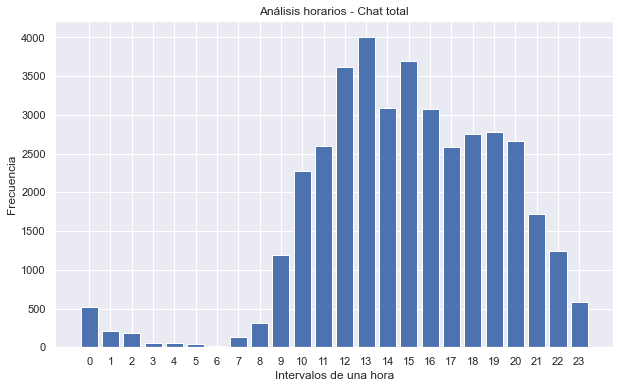

In [535]:
plot_graph(time_groups)

In [536]:
mi_df = df[df['Remitente']==mi_nombre]
otro_df = df[df['Remitente'] !=mi_nombre]

In [537]:
mi_time_groups = groupByHour(mi_df['Hora'])
otro_time_groups = groupByHour(otro_df['Hora'])

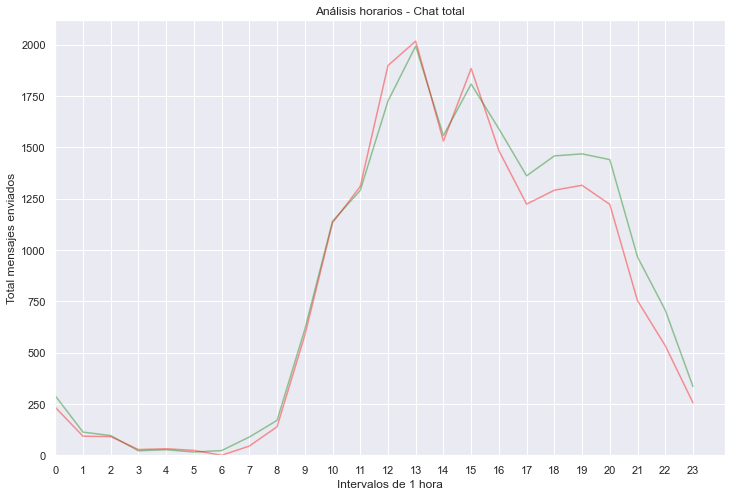

In [538]:
plt.figure(figsize=(12,8))
plt.plot(range(len(mi_time_groups)), list(mi_time_groups.values()),  color='green', alpha=0.4)
plt.plot(range(len(otro_time_groups)), list(otro_time_groups.values()), color='red', alpha=0.4)
plt.xticks(range(len(mi_time_groups)), list(mi_time_groups.keys()))
plt.xlim(0)
plt.ylim(0)
plt.xlabel('Intervalos de 1 hora')
plt.ylabel('Total mensajes enviados')
plt.title("Análisis horarios - Chat total")
plt.legend.location = 'top_left'
plt.grid(1)
plt.show()

# Procesamiento de texto


In [539]:

def split_count(text):

    emoji_list = []
    data = text
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)

    return emoji_list

total_mensajes = df.shape[0]
media_mensajes = df[df['Mensaje'] == '<Multimedia omitido>'].shape[0]
df["emoji"] = df["Mensaje"].apply(split_count)
emojis = sum(df['emoji'].str.len())
URLPATTERN = r'(https?://\S+)'
df['urlcount'] = df.Mensaje.apply(lambda x: re.findall(URLPATTERN, x)).str.len()
links = np.sum(df.urlcount)

In [540]:
print("Total mensajes: ",total_mensajes)
print("Multimedia: ",media_mensajes)
print("Emojis: ",emojis)
print("Links: ",links)

Total mensajes:  39415
Multimedia:  3514
Emojis:  3242
Links:  306


In [541]:
df['Cant letras'] = df['Mensaje'].apply(lambda s : len(s))
df['Cant Palabras'] = df['Mensaje'].apply(lambda s : len(s.split(' ')))

In [542]:
media_mensajes_df = df[df['Mensaje'] == '<Multimedia omitido>']
df2 = df.drop(media_mensajes_df.index)

## Series de tiempo de los mensajes 

In [543]:
totales = df2.groupby(["Fecha", "Remitente"]).agg(CantMsg=('Mensaje', 'count'), CantPalabras=('Cant Palabras', 'sum')).reset_index()


In [544]:
totales.index = pd.DatetimeIndex(totales.Fecha, dayfirst=True)
totales.drop("Fecha", axis=1, inplace=True)

In [545]:
totales['month'] = [d.strftime('%b') for d in totales.index]
totales['day'] = [d.strftime('%A') for d in totales.index]
totales = totales.sort_values(by = "Fecha")


In [546]:
totales_msg_mes = totales.groupby(["Fecha"])["CantMsg", "CantPalabras"].sum()
totales_msg_mes = totales_msg_mes.resample('MS').sum()

C:\Users\ioeye\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [547]:
totales_msg_mes_me = totales[totales["Remitente"]==mi_nombre].groupby(["Fecha"])["CantMsg", "CantPalabras"].sum()
totales_msg_mes_me = totales_msg_mes_me.resample('MS').sum()

C:\Users\ioeye\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [548]:
totales_msg_mes_not_me = totales[totales["Remitente"]!=mi_nombre].groupby(["Fecha"])["CantMsg", "CantPalabras"].sum()
totales_msg_mes_not_me = totales_msg_mes_not_me.resample('MS').sum()


C:\Users\ioeye\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [549]:
mi_hover_tool = HoverTool(
                tooltips=[("Fecha","@x{%F}"), ("Cantidad", "@y{int}")], formatters={"@x":"datetime"} )

def plottotal( x1, y1,  title, color,  y_axis_label):
    plot = bkplt.figure(x_axis_type="datetime", title=title,  plot_height=350, plot_width=650, tools = 'pan, box_zoom')
    plot.line(x1, y1,  legend_label="Valor de cada mes", color=color)
    plot.circle(x1, y1,   color=color)
    plot.xgrid.grid_line_color=None
    plot.ygrid.grid_line_alpha=0.5
    plot.xaxis.axis_label = 'Fecha'
    plot.yaxis.axis_label = y_axis_label
    plot.legend.location = 'bottom_left'
    plot.add_tools(mi_hover_tool)
    return plot

In [550]:
def plotcompartido( x1, y1, x2, y2, title, color, color2, y_axis_label):
    plot = bkplt.figure(x_axis_type="datetime", title=title,  plot_height=350, plot_width=650, tools = 'pan, box_zoom')
    plot.line(x1, y1,  legend_label="Cantidad enviada por mí", color=color)
    plot.circle(x1, y1,   color=color)
    plot.line(x2, y2,  color = color2, legend_label="Cantidad recibida")
    plot.square(x2, y2,  color = color2,  )
    plot.xgrid.grid_line_color=None
    plot.ygrid.grid_line_alpha=0.5
    plot.xaxis.axis_label = 'Fecha'
    plot.yaxis.axis_label = y_axis_label
    plot.legend.location = 'bottom_left'
    plot.add_tools(mi_hover_tool)
    return plot

In [551]:
plotMensajes = plottotal(totales_msg_mes.index, totales_msg_mes.CantMsg, "Total de mensajes", "blue", "Valores mes")
#show(plotMensajes)


In [552]:
plotPalabras = plottotal(totales_msg_mes.index, totales_msg_mes.CantPalabras, "Total de palabras", "green", "Palabras por mes")
#show(plotPalabras)


In [553]:


plotMensajes2 = plotcompartido(totales_msg_mes_me.index, totales_msg_mes_me.CantMsg, totales_msg_mes_not_me.index, totales_msg_mes_not_me.CantMsg, "Mensajes enviados", "red", "green", "Valores mes")


In [554]:
plotPalabras2 = plotcompartido(totales_msg_mes_me.index, totales_msg_mes_me.CantPalabras, totales_msg_mes_not_me.index, totales_msg_mes_not_me.CantPalabras, "Palabras enviadas", "red", "green", "Palabras por mes")


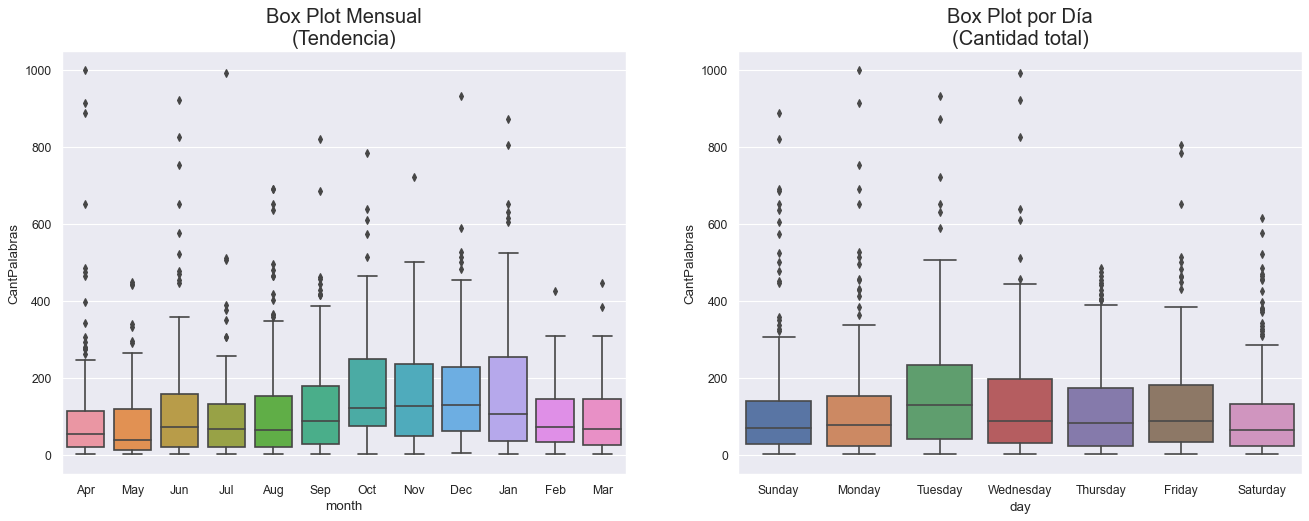

In [555]:
# Definimos los plots:
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='month', y="CantPalabras", data=totales, ax=axes[0])
sns.boxplot(x='day', y='CantPalabras', data=totales)

# Seteamos los títulos:
axes[0].set_title('Box Plot Mensual\n(Tendencia)', fontsize=18); 
axes[1].set_title('Box Plot por Día\n(Cantidad total)', fontsize=18)
plt.show()

# Análisis de emojis


In [556]:


total_emojis_list = list([a for b in df2.emoji for a in b])
emoji_dict = dict(Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)

emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
agregados_emoji = emoji_df[(emoji_df['emoji'] == '♀')|(emoji_df['emoji'] == '🏻')]
emoji_df.drop(agregados_emoji.index, inplace=True)
emoji_df = emoji_df.head(10)
emoji_df

,emoji,count
0,❤,854
1,😭,356
2,😂,290
3,😱,221
4,😞,176
7,🤣,84
8,🙈,73
9,😘,69
10,😡,61
11,👍,54


In [557]:
my_emojis_list = list([a for b in df2[df2['Remitente']==mi_nombre].emoji for a in b])
emoji_me_dict = dict(Counter(my_emojis_list))
emoji_me_dict = sorted(emoji_me_dict.items(), key=lambda x: x[1], reverse=True)

my_emoji_df = pd.DataFrame(emoji_me_dict, columns=['emoji', 'count'])
agregados_emoji_me = my_emoji_df[(my_emoji_df['emoji'] == '♀')|(my_emoji_df['emoji'] == '🏻')]
my_emoji_df.drop(agregados_emoji_me.index, inplace=True)
my_emoji_df = my_emoji_df.head(10)
my_emoji_df

,emoji,count
0,❤,658
1,😭,244
2,😂,214
3,😱,170
5,🤣,79
6,😘,69
8,👍,54
9,🙈,39
10,😡,36
11,😍,35


In [558]:
other_emojis_list = list([a for b in df2[df2['Remitente']!=mi_nombre].emoji for a in b])
emoji_other_dict = dict(Counter(other_emojis_list))
emoji_other_dict = sorted(emoji_other_dict.items(), key=lambda x: x[1], reverse=True)

other_emoji_df = pd.DataFrame(emoji_other_dict, columns=['emoji', 'count'])
agregados_emoji_other = other_emoji_df[(other_emoji_df['emoji'] == '♀')|(other_emoji_df['emoji'] == '🏻')]
other_emoji_df.drop(agregados_emoji_other.index, inplace=True)
other_emoji_df = other_emoji_df.head(10)
other_emoji_df

,emoji,count
0,❤,196
1,😞,176
2,😭,112
3,😂,76
4,😱,51
5,🙈,34
7,🤦,27
8,😡,25
9,🙏,23
10,😍,18


In [559]:
from bokeh.models import ColumnDataSource, Grid, HBar, LinearAxis, Plot
from bokeh.palettes import Spectral10

mi_hover_tool2 = HoverTool(
                tooltips=[("Cantidad","@counts"), ("Emoji", "@emojis")],  )
source = ColumnDataSource(data=dict(emojis=my_emoji_df['emoji'], counts=my_emoji_df['count'], color=Spectral10))


p_my_emojis = bkplt.figure(
  x_range=my_emoji_df['emoji'],
  y_range=(0,cantmaxemojis*1.1),
  title = 'Mis emojis más enviados',
  y_axis_label ='Cantidad veces utilizada',
  plot_width=650,
  plot_height=350,
  tools = 'pan, box_zoom'
)



p_my_emojis.xaxis.major_label_text_font_size = '20px'

p_my_emojis.vbar('emojis', width=0.6, top='counts', color='color', source=source,  fill_alpha=0.7, 
                 #legend="emojis"
                )



p_my_emojis.add_tools(mi_hover_tool2)
# show the results 
#show(p_my_emojis) 

In [560]:
source = ColumnDataSource(data=dict(emojis=other_emoji_df['emoji'], counts=other_emoji_df['count'], color=Spectral10))


p_other_emojis = bkplt.figure(
  x_range=other_emoji_df['emoji'],
  y_range=(0,cantmaxemojis*1.1),
  title = 'Sus emojis más enviados',
  y_axis_label ='Cantidad veces utilizada',
  plot_width=650,
  plot_height=350,
  tools = 'pan, box_zoom'
)
p_other_emojis.vbar('emojis', width=0.6, top='counts', color='color', source=source,  fill_alpha=0.7,
                    #legend="emojis"
                   )

p_other_emojis.xaxis.major_label_text_font_size = '20px'


p_other_emojis.add_tools(mi_hover_tool2)
# show the results 
#show(p_other_emojis) 

In [561]:
layout1 = gridplot([[p_my_emojis, p_other_emojis],[plotPalabras, plotMensajes],[plotPalabras2, plotMensajes2]], toolbar_location="right")
show(column(Div(text="<b> Whatsapp</b>", style={'font-size': '200%', 'color': 'grey', 'text-align': "right"}),layout1))

# Texto

In [562]:
textomensajes = df2['Mensaje'].to_string().lower()
a,b = 'áéíóúü','aeiouu'
trans = str.maketrans(a,b)

textomensajes = textomensajes.translate(trans)


In [563]:
textomensajes = re.sub('\s*(j*a*ja\w*)\s\w*|(j*a*ja\w*)$', '\\1-jajaja ', textomensajes)



<>:1: DeprecationWarning: invalid escape sequence \s
<>:3: DeprecationWarning: invalid escape sequence \s
<>:1: DeprecationWarning: invalid escape sequence \s
<>:3: DeprecationWarning: invalid escape sequence \s
<>:1: DeprecationWarning: invalid escape sequence \s
<>:3: DeprecationWarning: invalid escape sequence \s
<ipython-input-563-fe056e52cdd7>:1: DeprecationWarning: invalid escape sequence \s
  textomensajes = re.sub('\s*(j*a*ja\w*)\s\w*|(j*a*ja\w*)$', '\\1-jajaja ', textomensajes)
<ipython-input-563-fe056e52cdd7>:3: DeprecationWarning: invalid escape sequence \s
  textomensajes = re.sub('\s*(rup\w*\s)', ' ruperto ', textomensajes)


In [564]:
stop_words_sp = set(stopwords.words('spanish'))
stop_words_sp.update(["sip","nono","ahh", "ahhh","meno","ay","tene","nooo","ir","asi","tenia","iba","ser","estan","https","jajaj","pa", "eh", "si", "no", "ah", "che", "sisi", "sii","siii","aca","ahi","ahí","tmb","encima","re","desp","nah","tan", "siiii","oki","re","dp","porq","xq","tb","do","ma","capaz","so","vo","solo", "https", "http", "www"])

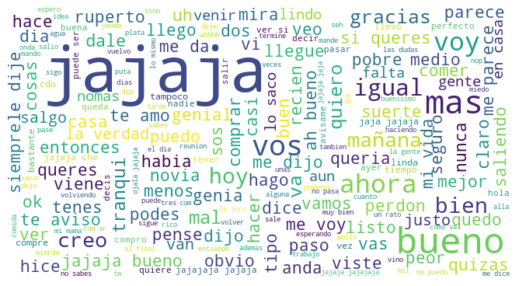

In [565]:
# Generate a word cloud image, 
wordcloud = WordCloud(stopwords=stop_words_sp, background_color="white", width=650, height=350, max_font_size=80, collocation_threshold=100,  normalize_plurals=False).generate(textomensajes)
  # Display the generated image:
  # the matplotlib way:
  
plt.figure( figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [566]:
textomismensajes = df2[df2['Remitente']==mi_nombre]['Mensaje'].to_string().lower()
a,b = 'áéíóúü','aeiouu'
trans = str.maketrans(a,b)

textomismensajes = textomismensajes.translate(trans)


textomismensajes = re.sub('\s*(j*a*ja\w*)\s\w*|(j*a*ja\w*)$', '\\1-jajaja ', textomismensajes)



<>:8: DeprecationWarning: invalid escape sequence \s
<>:11: DeprecationWarning: invalid escape sequence \s
<>:8: DeprecationWarning: invalid escape sequence \s
<>:11: DeprecationWarning: invalid escape sequence \s
<>:8: DeprecationWarning: invalid escape sequence \s
<>:11: DeprecationWarning: invalid escape sequence \s
<ipython-input-566-0c66f586ac24>:8: DeprecationWarning: invalid escape sequence \s
  textomismensajes = re.sub('\s*(j*a*ja\w*)\s\w*|(j*a*ja\w*)$', '\\1-jajaja ', textomismensajes)
<ipython-input-566-0c66f586ac24>:11: DeprecationWarning: invalid escape sequence \s
  textomismensajes = re.sub('\s*(rup\w*\s)', ' ruperto ', textomismensajes)


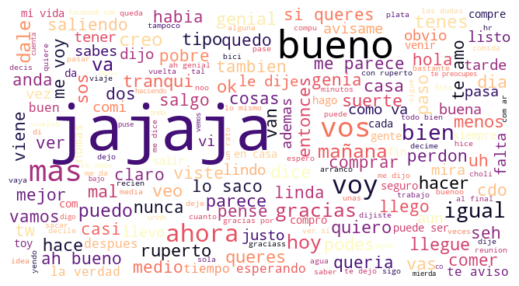

In [567]:
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stop_words_sp, background_color="white", width=650, height=350, max_font_size=80, colormap="magma", collocation_threshold=100,  normalize_plurals=False).generate(textomismensajes)
  # Display the generated image:
  # the matplotlib way:
  
plt.figure( figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [568]:
textosusmensajes = df2[df2['Remitente']!=mi_nombre]['Mensaje'].to_string().lower()
a,b = 'áéíóúü','aeiouu'
trans = str.maketrans(a,b)

textosusmensajes = textosusmensajes.translate(trans)
textosusmensajes = re.sub('\s*(j*a*ja\w*)\s\w*|(j*a*ja\w*)$', '\\1-jajaja ', textosusmensajes)


<>:6: DeprecationWarning: invalid escape sequence \s
<>:9: DeprecationWarning: invalid escape sequence \s
<>:6: DeprecationWarning: invalid escape sequence \s
<>:9: DeprecationWarning: invalid escape sequence \s
<>:6: DeprecationWarning: invalid escape sequence \s
<>:9: DeprecationWarning: invalid escape sequence \s
<ipython-input-568-b1b8fd71cc26>:6: DeprecationWarning: invalid escape sequence \s
  textosusmensajes = re.sub('\s*(j*a*ja\w*)\s\w*|(j*a*ja\w*)$', '\\1-jajaja ', textosusmensajes)
<ipython-input-568-b1b8fd71cc26>:9: DeprecationWarning: invalid escape sequence \s
  textosusmensajes = re.sub('\s*(rup\w*\s)', ' ruperto ', textosusmensajes)


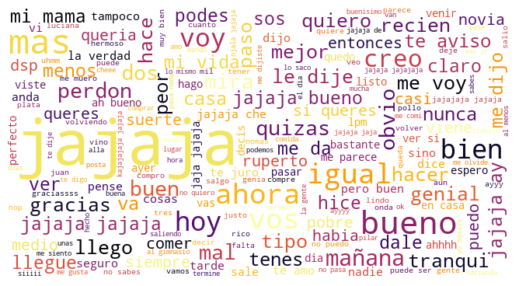

In [569]:
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stop_words_sp, background_color="white", width=650, height=350, max_font_size=80, colormap="inferno",  normalize_plurals=False).generate(textosusmensajes)
  # Display the generated image:
  # the matplotlib way:
  
plt.figure( figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()